# Retrieval evaluation

This notebook assesses the accuracy of the CCIC retrieval on the test data.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import cmocean
import matplotlib.pyplot as plt
from matplotlib import style
from ccic.plotting import set_style
from pathlib import Path
from tqdm import tqdm

set_style()
# DATA_PATH = Path("/home/simonpf/copper/ccic")
DATA_PATH = Path("/home/amell/mnt/ccic")

## Retrieval accuracy

In [2]:
from pathlib import Path
from ccic.processing import determine_cloud_class, determine_column_cloud_class
result_files_cpcir = sorted(list((DATA_PATH / "results/test_data/").glob("results_cpcir_*.nc")))
results_cpcir = []
for result_file in tqdm(np.random.permutation(result_files_cpcir)):
    
    with xr.open_dataset(result_file) as data:
        data = data.drop_vars(["encodings"]).load()
        cloud_class = determine_cloud_class(data.cloud_class_prob.data, axis=-1)
        data["cloud_class"] = (("samples", "levels"), cloud_class) 
        
        cc = determine_column_cloud_class(cloud_class)
        data["column_class"] = (("samples",), cc)
        
        results_cpcir.append(data)
        
results_cpcir = xr.concat(results_cpcir, "samples")

100%|██████████| 12/12 [03:00<00:00, 15.07s/it]


In [3]:
from pathlib import Path
result_files_gridsat = sorted(list((DATA_PATH / "results/test_data/").glob("results_gridsat*.nc")))
results_gridsat = []
for result_file in tqdm(np.random.permutation(result_files_gridsat)):
    
    with xr.open_dataset(result_file) as data:
        data = data.drop_vars(["encodings"]).load()
        cloud_class = determine_cloud_class(data.cloud_class_prob.data, axis=-1)
        data["cloud_class"] = (("samples", "levels"), cloud_class) 
        results_gridsat.append(data)
        
        cc = determine_column_cloud_class(cloud_class)
        data["column_class"] = (("samples",), cc)
        
results_gridsat = xr.concat(results_gridsat, "samples")

100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


### TIWP Retrieval accuracy

#### Scatter plots

In [4]:
# Commented out fpavg, but kept it in case we want to use it
# (it gives better marginally better results)

from scipy.stats import binned_statistic
bins = np.logspace(-3, 2, 201)
# y_cpc = np.histogram2d(results_cpcir.tiwp_fpavg_true.data, results_cpcir.tiwp_fpavg_mean.data, bins=bins, density=True)[0]
y_cpc = np.histogram2d(results_cpcir.tiwp_true.data, results_cpcir.tiwp_mean.data, bins=bins, density=True)[0]
y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]
cond_mean_cpc = binned_statistic(
    # results_cpcir.tiwp_fpavg_true.data,
    # results_cpcir.tiwp_fpavg_mean.data,
    results_cpcir.tiwp_true.data,
    results_cpcir.tiwp_mean.data,
    lambda x: x.mean() if x.size > 1e2 else np.nan,
    bins=bins)[0]
corr_cpc = np.corrcoef(
    # results_cpcir.tiwp_fpavg_true.data,
    # results_cpcir.tiwp_fpavg_mean.data
    results_cpcir.tiwp_true.data,
    results_cpcir.tiwp_mean.data
)[0, 1]
# bias_cpc = np.mean(results_cpcir.tiwp_fpavg_mean.data - results_cpcir.tiwp_fpavg_true.data) / np.mean(results_cpcir.tiwp_fpavg_mean.data)
bias_cpc = np.mean(results_cpcir.tiwp_mean.data - results_cpcir.tiwp_true.data) / np.mean(results_cpcir.tiwp_mean.data)

# y_gs = np.histogram2d(results_gridsat.tiwp_fpavg_true.data, results_gridsat.tiwp_fpavg_mean.data, bins=bins, density=True)[0]
y_gs = np.histogram2d(results_gridsat.tiwp_true.data, results_gridsat.tiwp_mean.data, bins=bins, density=True)[0]
y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]
cond_mean_gs = binned_statistic(
    # results_gridsat.tiwp_fpavg_true.data,
    # results_gridsat.tiwp_fpavg_mean.data,
    results_gridsat.tiwp_true.data,
    results_gridsat.tiwp_mean.data,
    lambda x: x.mean() if x.size > 1e2 else np.nan,
    bins=bins)[0]
corr_gs = np.corrcoef(
    # results_gridsat.tiwp_fpavg_true.data,
    # results_gridsat.tiwp_fpavg_mean.data
    results_gridsat.tiwp_true.data,
    results_gridsat.tiwp_mean.data
)[0, 1]
# bias_gs = np.mean(results_gridsat.tiwp_fpavg_mean.data - results_gridsat.tiwp_fpavg_true.data) / np.mean(results_gridsat.tiwp_fpavg_mean.data)
bias_gs = np.mean(results_gridsat.tiwp_mean.data - results_gridsat.tiwp_true.data) / np.mean(results_gridsat.tiwp_mean.data)

/tmp/ipykernel_170590/1148452661.py:8: RuntimeWarning: invalid value encountered in divide
  y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]
/tmp/ipykernel_170590/1148452661.py:27: RuntimeWarning: invalid value encountered in divide
  y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]


/tmp/ipykernel_170590/2251841968.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
/tmp/ipykernel_170590/2251841968.py:37: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")


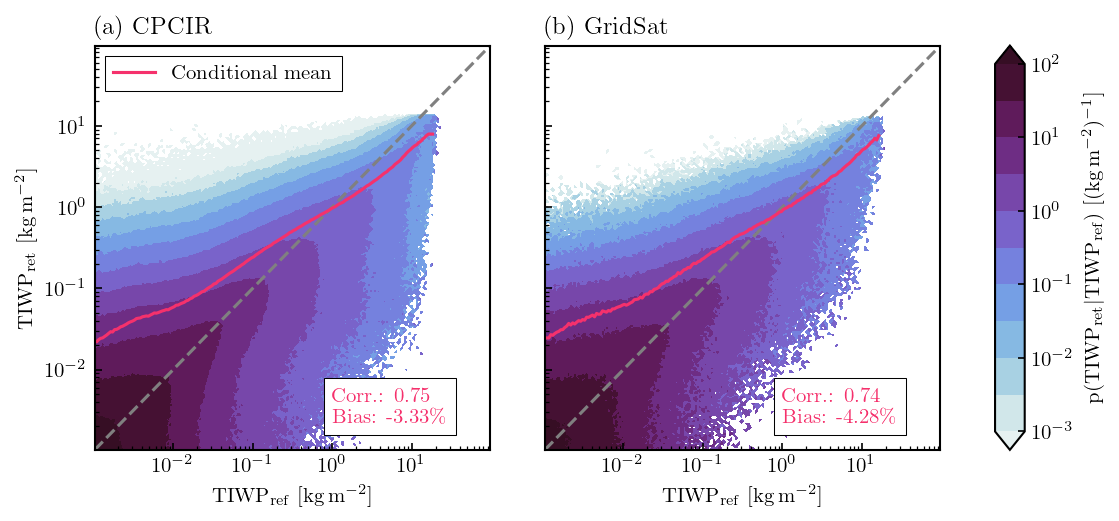

In [5]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(8, 3.5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

norm = LogNorm(1e-3, 1e2)
levels = np.logspace(-3, 2, 11)

txtcol = "C0"
diagcol = "orangered"

ax = fig.add_subplot(gs[0, 0])
ax.set_title("(a) CPCIR", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
for c in m.collections:
    c.set_rasterized(True)
    
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_cpc, c="C0", label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\text{TIWP}_\text{ret}$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.set_xlabel(r"$\text{TIWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
props = dict(facecolor='white', alpha=1.0, edgecolor="k")
ax.text(
    1, 2e-3, f"Corr.: {corr_cpc:0.2f} \n Bias: {100 * bias_cpc:0.2f}\%",
    fontsize=10, color=txtcol, ha="left", va="bottom", bbox=props
)
ax.legend()


ax = fig.add_subplot(gs[0, 1])
ax.set_title("(b) GridSat", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")
for c in m.collections:
    c.set_rasterized(True)
    
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_gs, c="C0", label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\text{TIWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
for l in ax.yaxis.get_ticklabels():
    l.set_visible(False)

props = dict(facecolor='white', alpha=1.0, edgecolor="k")
ax.text(1, 2e-3, f"Corr.: {corr_gs:0.2f} \n Bias: {100 * bias_gs:0.2f}\%",
        fontsize=10, color=txtcol, ha="left", va="bottom", bbox=props)

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, label=r"$\text{p}(\text{TIWP}_\text{ret} | \text{TIWP}_\text{ref}$) $[(\si{\kilo \gram \per \meter \squared})^{-1}$]", cax=ax)
# fig.savefig("../figures/scatter_tiwp_fpavg.pdf", dpi=200, bbox_inches="tight")
fig.savefig("../figures/scatter_tiwp.pdf", dpi=200, bbox_inches="tight")

#### Zonal distributions

In [6]:
iwp_max = 1e2
iwp_bins = np.logspace(-3, np.log10(iwp_max), 41)
lat_bins = np.linspace(-60, 60, 61)

y_cpc_true = np.histogram2d(
    results_cpcir.latitude.data,
    results_cpcir.tiwp_true.data,
    bins=(lat_bins, iwp_bins),
    density=True
)[0]
y_cpc_true /= np.trapz(np.diff(iwp_bins)[None] * y_cpc_true, axis=0)[None]
y_cpc_ret = np.histogram2d(
    results_cpcir.latitude.data,
    results_cpcir.tiwp_sample.data,
    bins=(lat_bins, iwp_bins),
    density=True
)[0]
y_cpc_ret /= np.trapz(np.diff(iwp_bins)[None] * y_cpc_ret, axis=0)[None]
mean_true_cpc = binned_statistic(results_cpcir.latitude.data, results_cpcir.tiwp_true.data, bins=lat_bins)[0]
mean_ret_cpc = binned_statistic(results_cpcir.latitude.data, results_cpcir.tiwp_mean.data, bins=lat_bins)[0]

y_gs_true = np.histogram2d(
    results_gridsat.latitude.data,
    results_gridsat.tiwp_true.data,
    bins=(lat_bins, iwp_bins),
    density=True
)[0]
y_gs_true /= np.trapz(np.diff(iwp_bins)[None] * y_gs_true, axis=0)[None]
y_gs_ret = np.histogram2d(
    results_gridsat.latitude.data,
    results_gridsat.tiwp_sample.data,
    bins=(lat_bins, iwp_bins),
    density=True
)[0]
y_gs_ret /= np.trapz(np.diff(iwp_bins)[None] * y_gs_ret, axis=0)[None]
mean_true_gs = binned_statistic(results_gridsat.latitude.data, results_gridsat.tiwp_true.data, bins=lat_bins)[0]
mean_ret_gs = binned_statistic(results_gridsat.latitude.data, results_gridsat.tiwp_mean.data, bins=lat_bins)[0]

/tmp/ipykernel_170590/1840223653.py:11: RuntimeWarning: invalid value encountered in divide
  y_cpc_true /= np.trapz(np.diff(iwp_bins)[None] * y_cpc_true, axis=0)[None]
/tmp/ipykernel_170590/1840223653.py:18: RuntimeWarning: invalid value encountered in divide
  y_cpc_ret /= np.trapz(np.diff(iwp_bins)[None] * y_cpc_ret, axis=0)[None]
/tmp/ipykernel_170590/1840223653.py:28: RuntimeWarning: invalid value encountered in divide
  y_gs_true /= np.trapz(np.diff(iwp_bins)[None] * y_gs_true, axis=0)[None]
/tmp/ipykernel_170590/1840223653.py:35: RuntimeWarning: invalid value encountered in divide
  y_gs_ret /= np.trapz(np.diff(iwp_bins)[None] * y_gs_ret, axis=0)[None]


/tmp/ipykernel_170590/1105517492.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Greys").copy()
/tmp/ipykernel_170590/1105517492.py:18: UserWarning: Log scale: values of z <= 0 have been masked
  m_filled = ax.contourf(iwps, lats, y_cpc_true, norm=norm, levels=levels, extend="max", cmap="Greys")
/tmp/ipykernel_170590/1105517492.py:21: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(iwps, lats, y_cpc_ret, norm=norm, levels=levels, linestyles="--", cmap="cmo.amp_r", linewidths=1)
/tmp/ipykernel_170590/1105517492.py:32: UserWarning: Log scale: values of z <= 0 have been masked
  m_filled = ax.contourf(iwps, lats, y_gs_true, norm=norm, levels=levels, extend="max", cmap="Greys")
/tmp/ipykernel_170590/1105517492.py:35: UserWarning: Log scale: values of z <= 0 have been masked
 

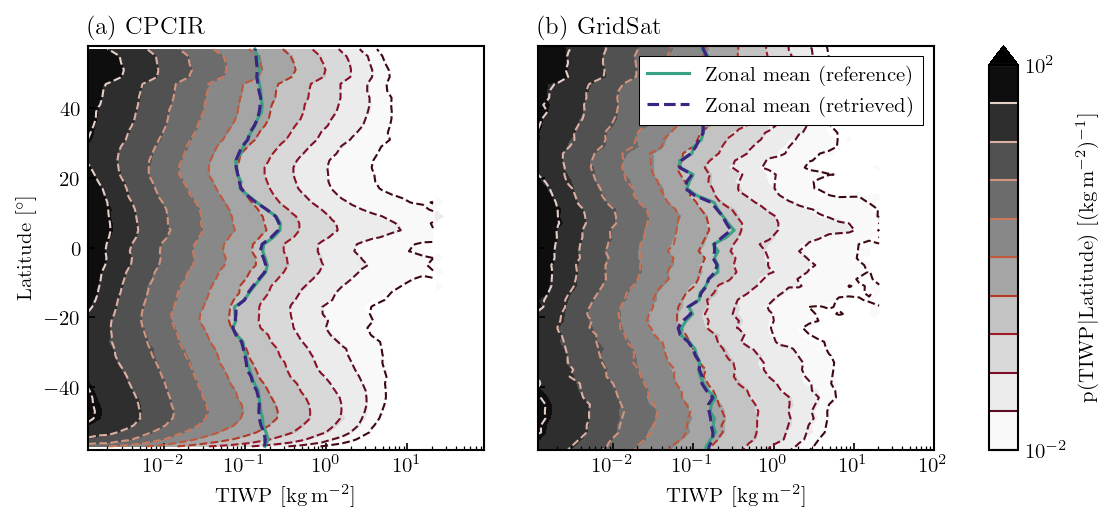

In [7]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap, ScalarMappable

fig = plt.figure(figsize=(8, 3.5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

lats = 0.5 * (lat_bins[1:] + lat_bins[:-1])
iwps = 0.5 * (iwp_bins[1:] + iwp_bins[:-1])
norm = LogNorm(1e-2, 1e2)
levels = np.logspace(-2, 2, 11)

m = ScalarMappable(norm=norm, cmap="Greys")
cmap = get_cmap("Greys").copy()
cmap.set_over(m.to_rgba(1e-2))

ax = fig.add_subplot(gs[0, 0])
m_filled = ax.contourf(iwps, lats, y_cpc_true, norm=norm, levels=levels, extend="max", cmap="Greys")
for c in m_filled.collections:
    c.set_rasterized(True)
ax.contour(iwps, lats, y_cpc_ret, norm=norm, levels=levels, linestyles="--", cmap="cmo.amp_r", linewidths=1)
ax.plot(mean_true_cpc, lats, c="C1")
ax.plot(mean_ret_cpc, lats, c="C2", ls="--")
ax.set_xlabel("TIWP [$\si{\kilo \gram \per \meter \squared}$]")
ax.set_ylabel("Latitude [$\si{\degree}$]")
ax.set_xscale("log")
ax.set_ylim([-58, 58])
ax.set_title("(a) CPCIR", loc="left")


ax = fig.add_subplot(gs[0, 1])
m_filled = ax.contourf(iwps, lats, y_gs_true, norm=norm, levels=levels, extend="max", cmap="Greys")
for c in m_filled.collections:
    c.set_rasterized(True)
m_cts = ax.contour(iwps, lats, y_gs_ret, norm=norm, levels=levels, linestyles="--", cmap="cmo.amp_r", linewidths=1)
ax.plot(mean_true_gs, lats, c="C1", label="Zonal mean (reference)")
ax.plot(mean_ret_gs, lats, c="C2", ls="--", label="Zonal mean (retrieved)")
ax.set_xlabel("TIWP [$\si{\kilo \gram \per \meter \squared}$]")
ax.set_xscale("log")
ax.set_ylim([-58, 58])
ax.set_xlim([0, iwp_max])
ax.set_title("(b) GridSat", loc="left")
for l in ax.yaxis.get_ticklabels():
    l.set_visible(False)
ax.legend()

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m_filled, cax=ax)
plt.colorbar(m_cts, label=r"$\text{p}(\text{TIWP} | \text{Latitude})$ [$(\si{\kilo \gram \per \meter \squared})^{-1}$]", cax=ax)
fig.savefig("../figures/zonal_dist_tiwp.pdf", bbox_inches="tight")

## Retrieval accuracy of TIWC

### Scatter plots

In [8]:
from scipy.stats import binned_statistic
bins = np.logspace(-3, 1, 201)
y_cpc = np.histogram2d(
    results_cpcir.tiwc_true.data.ravel(),
    results_cpcir.tiwc_mean.data.ravel(),
    bins=bins,
    density=True
)[0]
y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]

cond_mean_cpc = binned_statistic(
    results_cpcir.tiwc_true.data.ravel(),
    results_cpcir.tiwc_mean.data.ravel(),
    lambda x: x.mean() if x.size > 1e3 else np.nan,
    bins=bins
)[0]
corr_cpc = np.corrcoef(
    results_cpcir.tiwc_true.data.ravel(),
    results_cpcir.tiwc_mean.data.ravel()
)[0, 1]
bias_cpc = (
    np.mean(results_cpcir.tiwc_mean.data.ravel() - results_cpcir.tiwc_true.data.ravel()) / 
    np.mean(results_cpcir.tiwc_mean.data.ravel())
)

y_gs = np.histogram2d(
    results_gridsat.tiwc_true.data.ravel(),
    results_gridsat.tiwc_mean.data.ravel(),
    bins=bins, density=True)[0]
y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]

cond_mean_gs = binned_statistic(
    results_gridsat.tiwc_true.data.ravel(),
    results_gridsat.tiwc_mean.data.ravel(),
    lambda x: x.mean() if x.size > 1e3 else np.nan,
    bins=bins
)[0]
corr_gs = np.corrcoef(
    results_gridsat.tiwc_true.data.ravel(),
    results_gridsat.tiwc_mean.data.ravel()
)[0, 1]
bias_gs = (
    np.mean(results_gridsat.tiwc_mean.data.ravel() - results_gridsat.tiwc_true.data.ravel()) /
    np.mean(results_gridsat.tiwc_mean.data.ravel())
)

/tmp/ipykernel_170590/941036265.py:30: RuntimeWarning: invalid value encountered in divide
  y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]


/tmp/ipykernel_170590/3010504872.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
/tmp/ipykernel_170590/3010504872.py:35: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")


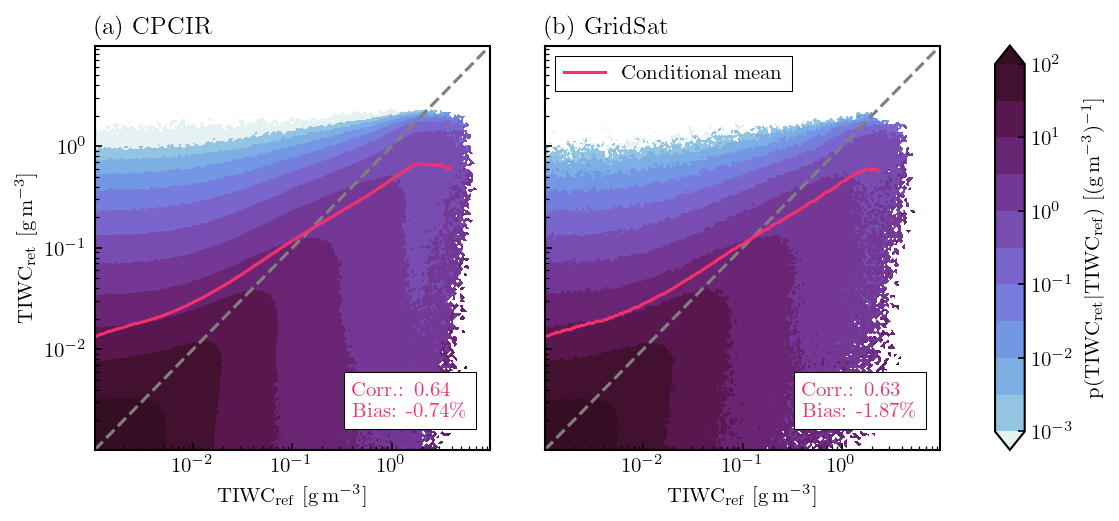

In [9]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(8, 3.5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

norm = LogNorm(1e-4, 1e2)
levels = np.logspace(-3, 2, 11)

txtcol = "C0"
diagcol = "C0"

ax = fig.add_subplot(gs[0, 0])
ax.set_title("(a) CPCIR", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
for c in m.collections:
    c.set_rasterized(True)
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_cpc, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\text{TIWC}_\text{ret}$ $[\si{\gram \per \meter \cubed}$]")
ax.set_xlabel(r"$\text{TIWC}_\text{ref}$ $[\si{\gram \per \meter \cubed}$]")
props = dict(facecolor='white', alpha=1.0, edgecolor="k")
ax.text(
    4e-1, 2e-3, f"Corr.: {corr_cpc:0.2f} \n Bias: {100 * bias_cpc:0.2f}\%",
    fontsize=10, color=txtcol, ha="left", va="bottom", bbox=props
)


ax = fig.add_subplot(gs[0, 1])
ax.set_title("(b) GridSat", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")
for c in m.collections:
    c.set_rasterized(True)
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_gs, c=diagcol, label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\text{TIWC}_\text{ref}$ $[\si{\gram \per \meter \cubed}$]")
props = dict(facecolor='white', alpha=1.0, edgecolor="k")
ax.text(4e-1, 2e-3, f"Corr.: {corr_gs:0.2f} \n Bias: {100 * bias_gs:0.2f}\%",
        fontsize=10, color=txtcol, ha="left", va="bottom", bbox=props)
ax.legend()
for l in ax.yaxis.get_ticklabels():
    l.set_visible(False)
    
ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, label=r"$\text{p}(\text{TIWC}_\text{ret} | \text{TIWC}_\text{ref}$) $[(\si{\gram \per \meter \cubed})^{-1}$]", cax=ax)
fig.savefig("../figures/scatter_plot_tiwc.pdf", dpi=200, bbox_inches="tight")

## Cloud detection

### Validation data

We begin by calculating precision and recall curves for the validation data, in order to determine an optimal decision threshold for the cloud classification.

Note: The optimal values derived in this section were implemented in the code used to determine the confusion matrix in the next section.

In [10]:
from sklearn.metrics import precision_recall_curve

In [11]:
results_cpcir_val = xr.load_dataset(DATA_PATH / "results" / "validation_data" / "validation_results_cpcir.nc")
results_gridsat_val = xr.load_dataset(DATA_PATH / "results" / "validation_data" / "validation_results_gridsat.nc")

In [12]:
# CPCIR
cp = results_cpcir_val.cloud_prob.data.ravel()
cp_true = results_cpcir_val.cloud_prob_true.data.ravel()
prec_cp_cpcir, rec_cp_cpcir, thresh = precision_recall_curve(
    cp_true.astype("bool"),
    cp
)

## p-2 distance to (1,1)
d = np.sqrt((1.0 - prec_cp_cpcir) ** 2 + (1.0 - rec_cp_cpcir) ** 2)

## Optimal values
t_cp_cpcir_val = thresh[np.argmin(d)]
prec_cp_cpcir_opt_val = prec_cp_cpcir[np.argmin(d)]
rec_cp_cpcir_opt_val = rec_cp_cpcir[np.argmin(d)]

# GridSat
cp = results_gridsat_val.cloud_prob.data.ravel()
cp_true = results_gridsat_val.cloud_prob_true.data.ravel()
prec_cp_gridsat, rec_cp_gridsat, thresh = precision_recall_curve(cp_true.astype("bool"), cp)

## p-2 distance to (1,1)
d = np.sqrt((1.0 - prec_cp_gridsat) ** 2 + (1.0 - rec_cp_gridsat) ** 2)

## Optimal values
t_cp_gridsat_val = thresh[np.argmin(d)]
prec_cp_gridsat_opt_val = prec_cp_gridsat[np.argmin(d)]
rec_cp_gridsat_opt_val = rec_cp_gridsat[np.argmin(d)]


In [13]:
import pandas as pd
pd.DataFrame({
    "Dataset": ["CPCIR", "GridSat"],
    "Threshold": [round(t_cp_cpcir_val, 3), round(t_cp_gridsat_val, 3)],
    "Precision": [round(prec_cp_cpcir_opt_val, 3), round(prec_cp_gridsat_opt_val, 3)],
    "Recall": [round(rec_cp_cpcir_opt_val, 3), round(rec_cp_gridsat_opt_val, 3)],
})

,Dataset,Threshold,Precision,Recall
0,CPCIR,0.448,0.838,0.865
1,GridSat,0.440,0.832,0.871


In [14]:
# CPCIR
cm = results_cpcir_val.cloud_class_prob.data[..., 0].ravel()
cm_true = results_cpcir_val.cloud_class_true.data.ravel() == 0
prec_cm_cpcir, rec_cm_cpcir, thresh = precision_recall_curve(
    ~cm_true,
    1.0 - cm
)
## p-2 distance to (1,1)
d = np.sqrt((1.0 - prec_cm_cpcir) ** 2 + (1.0 - rec_cm_cpcir) ** 2)
## Optimal values
t_cm_cpcir_val = thresh[np.argmin(d)]
prec_cm_cpcir_opt_val = prec_cm_cpcir[np.argmin(d)]
rec_cm_cpcir_opt_val = rec_cm_cpcir[np.argmin(d)]

# GridSat
cm = results_gridsat_val.cloud_class_prob.data[..., 0].ravel()
cm_true = results_gridsat_val.cloud_class_true.data.ravel() == 0
prec_cm_gridsat, rec_cm_gridsat, thresh = precision_recall_curve(
    ~cm_true,
    1.0 - cm
)
## p-2 distance to (1,1)
d = np.sqrt((1.0 - prec_cm_gridsat) ** 2 + (1.0 - rec_cm_gridsat) ** 2)
## Optimal values
t_cm_gridsat_val = thresh[np.argmin(d)]
prec_cm_gridsat_opt_val = prec_cm_gridsat[np.argmin(d)]
rec_cm_gridsat_opt_val = rec_cm_gridsat[np.argmin(d)]

In [15]:
import pandas as pd
pd.DataFrame({
    "Dataset": ["CPCIR", "GridSat"],
    "Threshold": [round(t_cm_cpcir_val, 3), round(t_cm_gridsat_val, 3)],
    "Precision": [round(prec_cm_cpcir_opt_val, 3), round(prec_cm_gridsat_opt_val, 3)],
    "Recall": [round(rec_cm_cpcir_opt_val, 3), round(rec_cm_gridsat_opt_val, 3)],
})

,Dataset,Threshold,Precision,Recall
0,CPCIR,0.360,0.685,0.741
1,GridSat,0.364,0.677,0.728


### Test data

In [16]:
from sklearn.metrics import precision_recall_curve

# CPCIR
cp = results_cpcir.cloud_prob.data.ravel()
cp_true = results_cpcir.cloud_prob_true.data.ravel()
prec_cp_cpcir, rec_cp_cpcir, thresh = precision_recall_curve(
    cp_true.astype("bool"),
    cp
)
## p-2 distance to (1,1)
d = np.sqrt((1.0 - prec_cp_cpcir) ** 2 + (1.0 - rec_cp_cpcir) ** 2)
## Optimal values
t_cp_cpcir = thresh[np.argmin(d)]
prec_cp_cpcir_opt = np.interp(t_cp_cpcir_val, thresh, prec_cp_cpcir[:-1])
rec_cp_cpcir_opt = np.interp(t_cp_cpcir_val, thresh, rec_cp_cpcir[:-1])

# GridSat
cp = results_gridsat.cloud_prob.data.ravel()
cp_true = results_gridsat.cloud_prob_true.data.ravel()
prec_cp_gridsat, rec_cp_gridsat, thresh = precision_recall_curve(cp_true.astype("bool"), cp)
## p-2 distance to (1,1)
d = np.sqrt((1.0 - prec_cp_gridsat) ** 2 + (1.0 - rec_cp_gridsat) ** 2)
## Optimal values
t_cp_gridsat = thresh[np.argmin(d)]
prec_cp_gridsat_opt = np.interp(t_cp_gridsat_val, thresh, prec_cp_gridsat[:-1])
rec_cp_gridsat_opt = np.interp(t_cp_gridsat_val, thresh, rec_cp_gridsat[:-1])

In [17]:
import pandas as pd
pd.DataFrame({
    "Dataset": ["CPCIR", "GridSat"],
    "Threshold test": [round(t_cp_cpcir, 3), round(t_cp_gridsat, 3)],
    "Threshold val": [round(t_cp_cpcir_val, 3), round(t_cp_gridsat_val, 3)],
    "Precision (with validation threshold)": [round(prec_cp_cpcir_opt, 3), round(prec_cp_gridsat_opt, 3)],
    "Recall (with validation threshold)": [round(rec_cp_cpcir_opt, 3), round(rec_cp_gridsat_opt, 3)],
})

,Dataset,Threshold test,Threshold val,Precision (with validation threshold),Recall (with validation threshold)
0,CPCIR,0.464,0.448,0.824,0.872
1,GridSat,0.472,0.440,0.820,0.878


In [18]:
cm = results_cpcir.cloud_class_prob.data[..., 0].ravel()
cm_true = results_cpcir.cloud_class_true.data.ravel() == 0
prec_cm_cpcir, rec_cm_cpcir, thresh = precision_recall_curve(
    ~cm_true,
    1.0 - cm
)
d = np.sqrt((1.0 - prec_cm_cpcir) ** 2 + (1.0 - rec_cm_cpcir) ** 2)
t_cm_cpcir = thresh[np.argmin(d)]
prec_cm_cpcir_opt = np.interp(t_cm_cpcir_val, thresh, prec_cm_cpcir[:-1])
rec_cm_cpcir_opt = np.interp(t_cm_cpcir_val, thresh, rec_cm_cpcir[:-1])

cm = results_gridsat.cloud_class_prob.data[..., 0].ravel()
cm_true = results_gridsat.cloud_class_true.data.ravel() == 0
prec_cm_gridsat, rec_cm_gridsat, thresh = precision_recall_curve(
    ~cm_true,
    1.0 - cm
)
d = np.sqrt((1.0 - prec_cm_gridsat) ** 2 + (1.0 - rec_cm_gridsat) ** 2)
t_cm_gridsat = thresh[np.argmin(d)]
prec_cm_gridsat_opt = np.interp(t_cm_gridsat_val, thresh, prec_cm_gridsat[:-1])
rec_cm_gridsat_opt = np.interp(t_cm_gridsat_val, thresh, rec_cm_gridsat[:-1])

In [19]:
import pandas as pd
pd.DataFrame({
    "Dataset": ["CPCIR", "GridSat"],
    "Threshold test": [round(t_cm_cpcir, 3), round(t_cm_gridsat, 3)],
    "Threshold val": [round(t_cm_cpcir_val, 3), round(t_cm_gridsat_val, 3)],
    "Precision (with validation threshold)": [round(prec_cm_cpcir_opt, 3), round(prec_cm_gridsat_opt, 3)],
    "Recall (with validation threshold)": [round(rec_cm_cpcir_opt, 3), round(rec_cm_gridsat_opt, 3)],
})

,Dataset,Threshold test,Threshold val,Precision (with validation threshold),Recall (with validation threshold)
0,CPCIR,0.368,0.360,0.671,0.739
1,GridSat,0.368,0.364,0.670,0.737


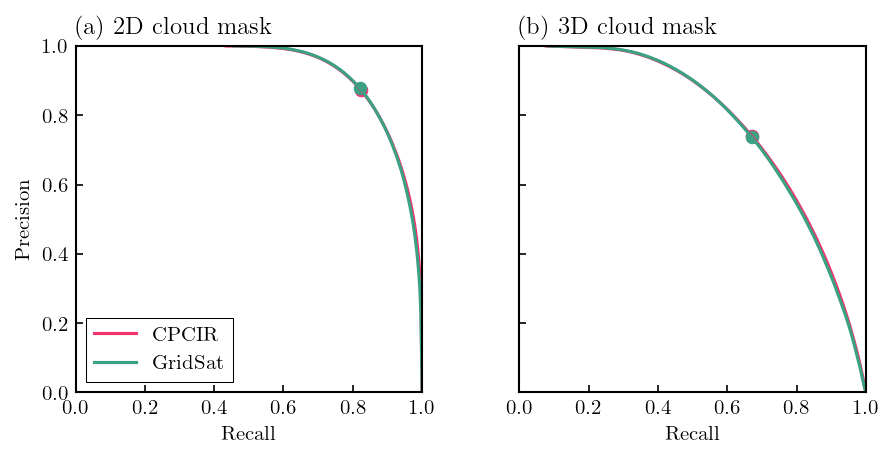

In [20]:
from matplotlib.gridspec import GridSpec

f = plt.figure(figsize=(7, 3))
gs = GridSpec(1, 2, width_ratios=[1.0, 1.0])

ax = f.add_subplot(gs[0, 0])
ax.plot(prec_cp_cpcir, rec_cp_cpcir, label="CPCIR", c="C0")
ax.scatter([prec_cp_cpcir_opt], [rec_cp_cpcir_opt], c="C0")
ax.plot(prec_cp_gridsat, rec_cp_gridsat, label="GridSat", c="C1")
ax.scatter([prec_cp_gridsat_opt], [rec_cp_gridsat_opt], c="C1")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.set_title("(a) 2D cloud mask", loc="left")
ax.set_aspect(1.0)
ax.legend(loc="lower left")

ax = f.add_subplot(gs[0, 1])
handles = []
handles += ax.plot(prec_cm_cpcir, rec_cm_cpcir, label="CPCIR", c="C0")
ax.scatter([prec_cm_cpcir_opt], [rec_cm_cpcir_opt], c="C0")
handles += ax.plot(prec_cm_gridsat, rec_cm_gridsat, label="GridSat", c="C1")
ax.scatter([prec_cm_gridsat_opt], [rec_cm_gridsat_opt], c="C1")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("Recall")
ax.set_aspect(1.0)
ax.set_title("(b) 3D cloud mask", loc="left")

ax.set_yticklabels([])
# for l in ax.yaxis.get_ticklines():
#     l.set_visible(False)
    

f.savefig("../figures/cloud_detection_prec_rec.pdf")

### Confusion matrix

Note: the cloud classes were determined using the treshold for the validation set determined in the previous section.

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
cc = results_cpcir.cloud_class.data.ravel()
cc_t = results_cpcir.cloud_class_true.data.ravel()
valid = cc_t <= 8
cc = cc[valid]
cc_t = cc_t[valid]
cm_cpcir = confusion_matrix(cc_t, cc, normalize="true")

cc = results_gridsat.cloud_class.data.ravel()
cc_t = results_gridsat.cloud_class_true.data.ravel()
valid = cc_t <= 8
cc = cc[valid]
cc_t = cc_t[valid]
cm_gridsat = confusion_matrix(cc_t, cc, normalize="true")

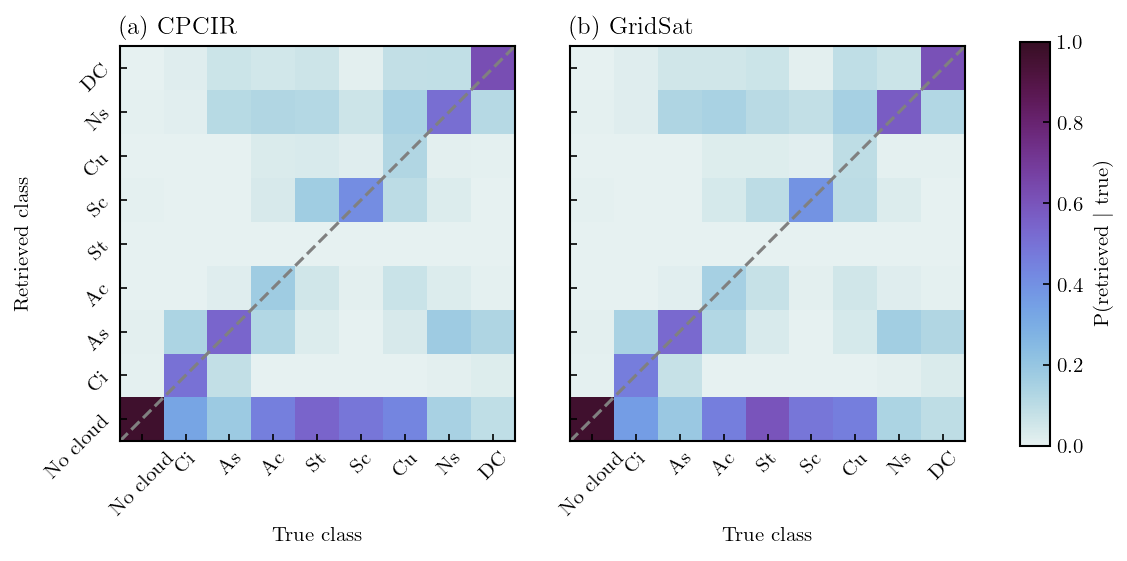

In [23]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from ccic.data.cloudsat import CLOUD_CLASSES

fig = plt.figure(figsize=(8, 3.5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])
norm = Normalize(0, 1)

ax = fig.add_subplot(gs[0, 0])
ax.pcolormesh(cm_cpcir.T, norm=norm, rasterized=True)
ax.set_xticks(np.arange(9) + 0.5)
ax.set_xticklabels(CLOUD_CLASSES)
for l in ax.xaxis.get_ticklabels():
    l.set_rotation(45)
ax.set_yticks(np.arange(9) + 0.5)
ax.set_yticklabels(CLOUD_CLASSES)
for l in ax.yaxis.get_ticklabels():
    l.set_rotation(45)
ax.set_title("(a) CPCIR", loc="left")
ax.set_xlabel("True class")
ax.set_ylabel("Retrieved class")
ax.set_aspect(1.0)
ax.plot(np.arange(10), np.arange(10), c="grey", ls="--")

ax = fig.add_subplot(gs[0, 1])
m = ax.pcolormesh(cm_gridsat.T, norm=norm, rasterized=True)
ax.set_xticks(np.arange(9) + 0.5)
ax.set_xticklabels(CLOUD_CLASSES)
ax.set_yticks(np.arange(9) + 0.5)
ax.set_yticklabels(CLOUD_CLASSES)
for l in ax.xaxis.get_ticklabels():
    l.set_rotation(45)
for l in ax.yaxis.get_ticklabels():
    l.set_visible(False)
ax.set_title("(b) GridSat", loc="left")
ax.set_xlabel("True class")
ax.set_aspect(1.0)
ax.plot(np.arange(10), np.arange(10), c="grey", ls="--")

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, cax=ax, label="P(retrieved $|$ true)")

fig.savefig("../figures/confusion_matrix_cloud_mask.pdf", bbox_inches="tight")

## Column classification

In [24]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

# CPCIR
valid = np.isfinite(results_cpcir.tbs) & np.isfinite(results_cpcir.tiwp_mean) & (results_cpcir.column_class >= 0)
tbs = results_cpcir.tbs.data[valid]
tiwp = results_cpcir.tiwp_mean.data[valid]
cc = results_cpcir.column_class.data[valid]

# Note: negating tbs reverses the ordering of the scores
# so that higher Tb's correspond to the no-cloud class (False)
# and lower Tb's correspond to the cloud class (True)
prec_cloud_tbs_cpcir, rec_cloud_tbs_cpcir, _ = precision_recall_curve(cc > 0, -tbs)
prec_cloud_tiwp_cpcir, rec_cloud_tiwp_cpcir, t_cloud_cpcir = precision_recall_curve(cc > 0, tiwp)
prec_feng_cloud_cpcir, recall_feng_cloud_cpcir, _, _ = precision_recall_fscore_support(cc > 0, tbs < 225)
opt_cloud_cpcir = np.argmin(np.sqrt((1 - prec_cloud_tiwp_cpcir) ** 2 + (1 - rec_cloud_tiwp_cpcir) ** 2))

prec_conv_tbs_cpcir, rec_conv_tbs_cpcir, _ = precision_recall_curve(cc > 1, -tbs)
prec_conv_tiwp_cpcir, rec_conv_tiwp_cpcir, t_conv_cpcir = precision_recall_curve(cc > 1, tiwp)
prec_feng_conv_cpcir, recall_feng_conv_cpcir, _, _ = precision_recall_fscore_support(cc > 1, tbs <= 240)
opt_conv_cpcir = np.argmin(np.sqrt((1 - prec_conv_tiwp_cpcir) ** 2 + (1 - rec_conv_tiwp_cpcir) ** 2))

# GridSat
valid = np.isfinite(results_gridsat.tbs) & np.isfinite(results_gridsat.tiwp_mean) & (results_gridsat.column_class >= 0)
tbs = results_gridsat.tbs.data[valid]
tiwp = results_gridsat.tiwp_mean.data[valid]
cc = results_gridsat.column_class.data[valid]

prec_cloud_tbs_gridsat, rec_cloud_tbs_gridsat, _ = precision_recall_curve(cc > 0, -tbs)
prec_cloud_tiwp_gridsat, rec_cloud_tiwp_gridsat, t_cloud_gridsat = precision_recall_curve(cc > 0, tiwp)
prec_feng_cloud_gridsat, recall_feng_cloud_gridsat, _, _ = precision_recall_fscore_support(cc > 0, tbs < 225)
opt_cloud_gridsat = np.argmin(np.sqrt((1 - prec_cloud_tiwp_gridsat) ** 2 + (1 - rec_cloud_tiwp_gridsat) ** 2))

prec_conv_tbs_gridsat, rec_conv_tbs_gridsat, _ = precision_recall_curve(cc > 1, -tbs)
prec_conv_tiwp_gridsat, rec_conv_tiwp_gridsat, t_conv_gridsat = precision_recall_curve(cc > 1, tiwp)
prec_feng_conv_gridsat, recall_feng_conv_gridsat, _, _ = precision_recall_fscore_support(cc > 1, tbs <= 240)
opt_conv_gridsat = np.argmin(np.sqrt((1 - prec_conv_tiwp_gridsat) ** 2 + (1 - rec_conv_tiwp_gridsat) ** 2))

In [25]:
(t_cloud_cpcir[opt_cloud_cpcir], t_conv_cpcir[opt_conv_cpcir]), (t_cloud_gridsat[opt_cloud_gridsat], t_conv_gridsat[opt_conv_gridsat])

((0.009163424, 0.1829134), (0.011577391, 0.15825468))

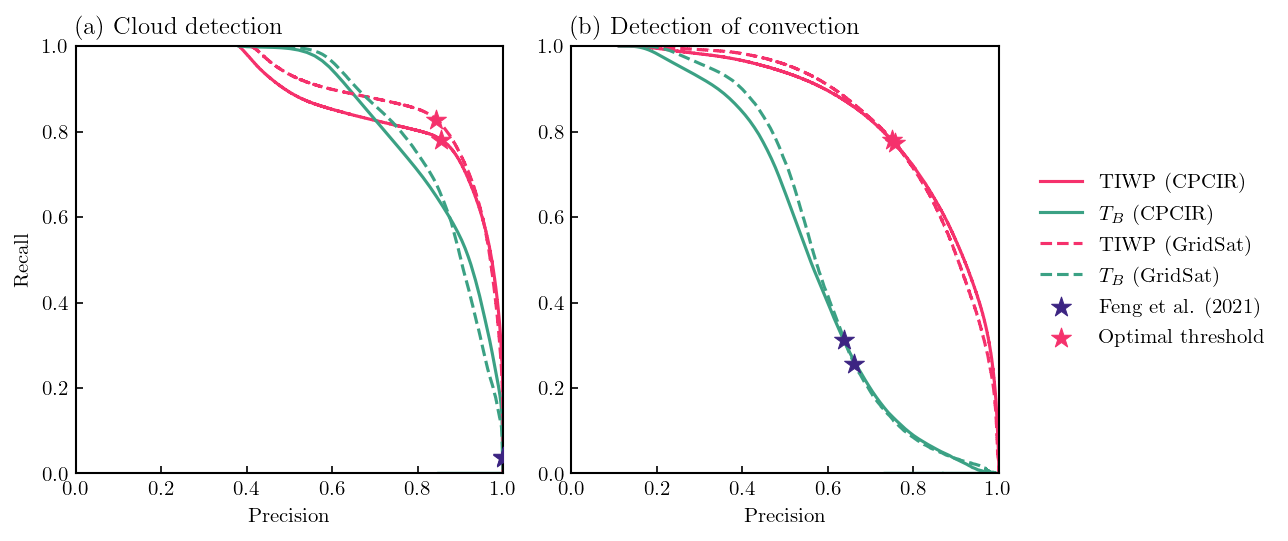

In [26]:
from matplotlib.gridspec import GridSpec
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.4])
f = plt.figure(figsize=(10, 4))

ax = f.add_subplot(gs[0, 0])
handles = []
handles += ax.plot(prec_cloud_tiwp_cpcir, rec_cloud_tiwp_cpcir, label="TIWP (CPCIR)", c="C0")
handles += ax.plot(prec_cloud_tbs_cpcir, rec_cloud_tbs_cpcir, label="$T_B$ (CPCIR)", c="C1")
handles += ax.plot(prec_cloud_tiwp_gridsat, rec_cloud_tiwp_gridsat, label="TIWP (GridSat)", c="C0", ls="--")
handles += ax.plot(prec_cloud_tbs_gridsat, rec_cloud_tbs_gridsat, label="$T_B$ (GridSat)", c="C1", ls="--")
handles.append(ax.scatter(prec_feng_cloud_cpcir[1], recall_feng_cloud_cpcir[1], marker="*", c="C2", label ="Feng et al. (2021)", zorder=20, s=100))
ax.scatter(prec_feng_cloud_gridsat[1], recall_feng_cloud_gridsat[1], marker="*", c="C2", zorder=20, s=100)
handles.append(ax.scatter([prec_cloud_tiwp_cpcir[opt_cloud_cpcir]], [rec_cloud_tiwp_cpcir[opt_cloud_cpcir]], marker="*", c="C0", zorder=20, s=100, label="Optimal threshold"))
ax.scatter([prec_cloud_tiwp_gridsat[opt_cloud_gridsat]], [rec_cloud_tiwp_gridsat[opt_cloud_gridsat]], marker="*", c="C0", zorder=20, s=100)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.set_title("(a) Cloud detection", loc="left")
ax.set_aspect(1.0)

ax = f.add_subplot(gs[0, 1])
ax.plot(prec_conv_tiwp_cpcir, rec_conv_tiwp_cpcir, label="TIWP (CPCIR)", c="C0")
ax.plot(prec_conv_tbs_cpcir, rec_conv_tbs_cpcir, label="$T_B$ (CPCIR)", c="C1")
ax.plot(prec_conv_tiwp_gridsat, rec_conv_tiwp_gridsat, label="TIWP (GridSat)", c="C0", ls="--")
ax.plot(prec_conv_tbs_gridsat, rec_conv_tbs_gridsat, label="$T_B$ (GridSat)", c="C1", ls="--")
ax.scatter(prec_feng_conv_cpcir[1], recall_feng_conv_cpcir[1], marker="*", c="C2", zorder=20, s=100)
ax.scatter(prec_feng_conv_gridsat[1], recall_feng_conv_gridsat[1], marker="*", c="C2", zorder=20, s=100)
ax.scatter([prec_conv_tiwp_cpcir[opt_conv_cpcir]], [rec_conv_tiwp_cpcir[opt_conv_cpcir]], marker="*", c="C0", zorder=20, s=100)
ax.scatter([prec_conv_tiwp_gridsat[opt_conv_gridsat]], [rec_conv_tiwp_gridsat[opt_conv_gridsat]], marker="*", c="C0", zorder=20, s=100)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("Precision")
ax.set_title("(b) Detection of convection", loc="left")
ax.set_aspect(1.0)

ax = f.add_subplot(gs[0, -1])
ax.set_axis_off()
ax.legend(handles=handles, loc="center", edgecolor="none", facecolor="none")

f.savefig("../figures/cloud_detection.pdf", bbox_inches="tight")

## TIWP vs $\int \text{TIWC} \, d\text{altitude}$

In [27]:
from ccic.data.cloudsat import ALTITUDE_LEVELS

tiwp_retrieved_gridsat = results_gridsat.tiwp_mean.values
tiwp_trapz_retrieved_gridsat = np.trapz(results_gridsat.tiwc_mean, ALTITUDE_LEVELS, axis=1) * 1e-3 # grams to kilograms
tiwp_retrieved_cpcir = results_cpcir.tiwp_mean.values
tiwp_trapz_retrieved_cpcir = np.trapz(results_cpcir.tiwc_mean, ALTITUDE_LEVELS, axis=1) * 1e-3 # grams to kilograms

tiwp_true_gridsat = results_gridsat.tiwp_true.values
tiwp_trapz_true_gridsat = np.trapz(results_gridsat.tiwc_true, ALTITUDE_LEVELS, axis=1) * 1e-3 # grams to kilograms
tiwp_true_cpcir = results_cpcir.tiwp_true.values
tiwp_trapz_true_cpcir = np.trapz(results_cpcir.tiwc_true, ALTITUDE_LEVELS, axis=1) * 1e-3 # grams to kilograms

In [28]:
from scipy.stats import binned_statistic
bins = np.logspace(-3, 2, 201)
y_cpc = np.histogram2d(tiwp_retrieved_cpcir, tiwp_trapz_retrieved_cpcir, bins=bins, density=True)[0]
y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]
cond_mean_cpc = binned_statistic(
    tiwp_retrieved_cpcir,
    tiwp_trapz_retrieved_cpcir,
    lambda x: x.mean() if x.size > 1e2 else np.nan,
    bins=bins)[0]
corr_cpc = np.corrcoef(
    tiwp_retrieved_cpcir,
    tiwp_trapz_retrieved_cpcir
)[0, 1]
bias_cpc = np.mean(tiwp_trapz_retrieved_cpcir - tiwp_retrieved_cpcir) / np.mean(tiwp_trapz_retrieved_cpcir)

y_gs = np.histogram2d(tiwp_retrieved_gridsat, tiwp_trapz_retrieved_gridsat, bins=bins, density=True)[0]
y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]
cond_mean_gs = binned_statistic(
    tiwp_retrieved_gridsat,
    tiwp_trapz_retrieved_gridsat,
    lambda x: x.mean() if x.size > 1e2 else np.nan,
    bins=bins)[0]
corr_gs = np.corrcoef(
    tiwp_retrieved_gridsat,
    tiwp_trapz_retrieved_gridsat
)[0, 1]
bias_gs = np.mean(tiwp_trapz_retrieved_gridsat - tiwp_retrieved_gridsat) / np.mean(tiwp_trapz_retrieved_gridsat)

/tmp/ipykernel_170590/320075072.py:4: RuntimeWarning: invalid value encountered in divide
  y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]
/tmp/ipykernel_170590/320075072.py:17: RuntimeWarning: invalid value encountered in divide
  y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]


/tmp/ipykernel_170590/395771135.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
/tmp/ipykernel_170590/395771135.py:37: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")


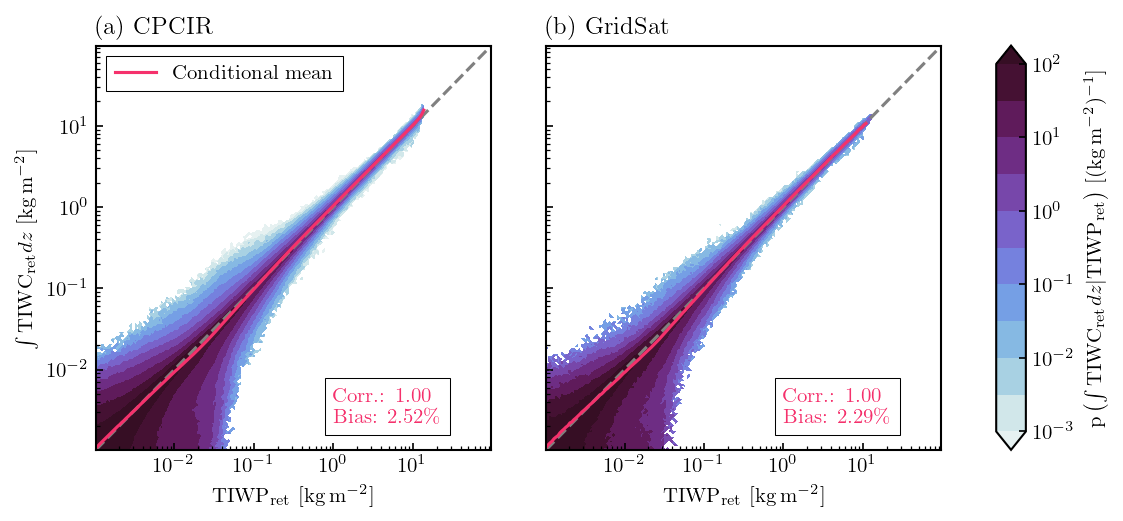

In [29]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(8, 3.5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

norm = LogNorm(1e-3, 1e2)
levels = np.logspace(-3, 2, 11)

txtcol = "C0"
diagcol = "orangered"

ax = fig.add_subplot(gs[0, 0])
ax.set_title("(a) CPCIR", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
for c in m.collections:
    c.set_rasterized(True)
    
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_cpc, c="C0", label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\int \text{TIWC}_\text{ret} dz$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.set_xlabel(r"$\text{TIWP}_\text{ret}$ $[\si{\kilo \gram \per \meter \squared}$]")
props = dict(facecolor='white', alpha=1.0, edgecolor="k")
ax.text(
    1, 2e-3, f"Corr.: {corr_cpc:0.2f} \n Bias: {100 * bias_cpc:0.2f}\%",
    fontsize=10, color=txtcol, ha="left", va="bottom", bbox=props
)
ax.legend()


ax = fig.add_subplot(gs[0, 1])
ax.set_title("(b) GridSat", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")
for c in m.collections:
    c.set_rasterized(True)
    
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_gs, c="C0", label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\text{TIWP}_\text{ret}$ $[\si{\kilo \gram \per \meter \squared}$]")
for l in ax.yaxis.get_ticklabels():
    l.set_visible(False)

props = dict(facecolor='white', alpha=1.0, edgecolor="k")
ax.text(1, 2e-3, f"Corr.: {corr_gs:0.2f} \n Bias: {100 * bias_gs:0.2f}\%",
        fontsize=10, color=txtcol, ha="left", va="bottom", bbox=props)

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, label=r"$\text{p}\left(\int \text{TIWC}_\text{ret} dz | \text{TIWP}_\text{ret} \right)$ $[(\si{\kilo \gram \per \meter \squared})^{-1}$]", cax=ax)
fig.savefig("../figures/tiwp_ret_vs_tiwc_trapz_ret.pdf", dpi=200, bbox_inches="tight")

In [30]:
bins = np.logspace(-3, 2, 201)
y_cpc = np.histogram2d(tiwp_true_cpcir, tiwp_trapz_retrieved_cpcir, bins=bins, density=True)[0]
y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]
cond_mean_cpc = binned_statistic(
    tiwp_true_cpcir,
    tiwp_trapz_retrieved_cpcir,
    lambda x: x.mean() if x.size > 1e2 else np.nan,
    bins=bins)[0]
corr_cpc = np.corrcoef(
    tiwp_true_cpcir,
    tiwp_trapz_retrieved_cpcir
)[0, 1]
bias_cpc = np.mean(tiwp_trapz_retrieved_cpcir - tiwp_true_cpcir) / np.mean(tiwp_trapz_retrieved_cpcir)

y_gs = np.histogram2d(tiwp_true_gridsat, tiwp_trapz_retrieved_gridsat, bins=bins, density=True)[0]
y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]
cond_mean_gs = binned_statistic(
    tiwp_true_gridsat,
    tiwp_trapz_retrieved_gridsat,
    lambda x: x.mean() if x.size > 1e2 else np.nan,
    bins=bins)[0]
corr_gs = np.corrcoef(
    tiwp_true_gridsat,
    tiwp_trapz_retrieved_gridsat
)[0, 1]
bias_gs = np.mean(tiwp_trapz_retrieved_gridsat - tiwp_true_gridsat) / np.mean(tiwp_trapz_retrieved_gridsat)

/tmp/ipykernel_170590/3733402013.py:3: RuntimeWarning: invalid value encountered in divide
  y_cpc /= np.trapz(np.diff(bins) * y_cpc, axis=-1)[..., None]
/tmp/ipykernel_170590/3733402013.py:16: RuntimeWarning: invalid value encountered in divide
  y_gs /= np.trapz(np.diff(bins) * y_gs, axis=-1)[..., None]


/tmp/ipykernel_170590/3763871272.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
/tmp/ipykernel_170590/3763871272.py:34: UserWarning: Log scale: values of z <= 0 have been masked
  m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")


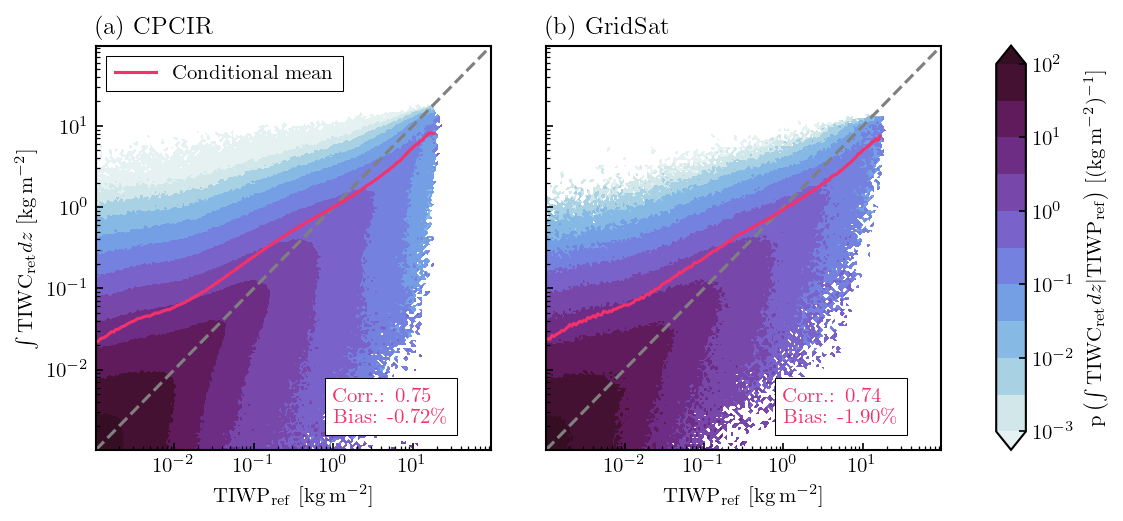

In [31]:
fig = plt.figure(figsize=(8, 3.5))
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.075])

norm = LogNorm(1e-3, 1e2)
levels = np.logspace(-3, 2, 11)

txtcol = "C0"
diagcol = "orangered"

ax = fig.add_subplot(gs[0, 0])
ax.set_title("(a) CPCIR", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_cpc.T, norm=norm, levels=levels, extend="both")
for c in m.collections:
    c.set_rasterized(True)
    
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_cpc, c="C0", label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\int \text{TIWC}_\text{ret} dz$ $[\si{\kilo \gram \per \meter \squared}$]")
ax.set_xlabel(r"$\text{TIWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
props = dict(facecolor='white', alpha=1.0, edgecolor="k")
ax.text(
    1, 2e-3, f"Corr.: {corr_cpc:0.2f} \n Bias: {100 * bias_cpc:0.2f}\%",
    fontsize=10, color=txtcol, ha="left", va="bottom", bbox=props
)
ax.legend()


ax = fig.add_subplot(gs[0, 1])
ax.set_title("(b) GridSat", loc="left")
x = 0.5 * (bins[1:] + bins[:-1])
m = ax.contourf(x, x, y_gs.T, norm=norm, levels=levels, extend="both")
for c in m.collections:
    c.set_rasterized(True)
    
ax.plot(x, x, ls="--", c="grey")
ax.plot(x, cond_mean_gs, c="C0", label="Conditional mean")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$\text{TIWP}_\text{ref}$ $[\si{\kilo \gram \per \meter \squared}$]")
for l in ax.yaxis.get_ticklabels():
    l.set_visible(False)

props = dict(facecolor='white', alpha=1.0, edgecolor="k")
ax.text(1, 2e-3, f"Corr.: {corr_gs:0.2f} \n Bias: {100 * bias_gs:0.2f}\%",
        fontsize=10, color=txtcol, ha="left", va="bottom", bbox=props)

ax = fig.add_subplot(gs[0, 2])
plt.colorbar(m, label=r"$\text{p}\left(\int \text{TIWC}_\text{ret} dz | \text{TIWP}_\text{ref} \right)$ $[(\si{\kilo \gram \per \meter \squared})^{-1}$]", cax=ax)
fig.savefig("../figures/tiwp_true_vs_tiwc_trapz_retrieved.pdf", dpi=200, bbox_inches="tight")